Stephanie Shaw, xyt-2, 2344808735

In [51]:
import tensorflow as tf
import keras
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [82]:
pip list

Package                      Version      Editable project location
---------------------------- ------------ -------------------------
absl-py                      2.1.0
anyio                        3.5.0
appnope                      0.1.2
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    2.0.5
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.11.0
beautifulsoup4               4.12.2
beautifultable               1.1.0
bleach                       4.1.0
bootstrapped                 0.0.2
Bottleneck                   1.3.5
Brotli                       1.0.9
certifi                      2024.2.2
cffi                         1.16.0
charset-normalizer           2.0.4
colour                       0.1.5
comm                         0.1.2
contourpy                    1.2.0
cryptography                 41.0.7
cycler                       0.11.0
debugpy      

In [52]:
# tf.get_logger().setLevel('ERROR')

In [53]:
train_data = pd.DataFrame(columns=['text','label'])
test_data = pd.DataFrame(columns=['text','label'])
unique_word = set()

In [54]:
def label_files(directory, label):
    for filename in os.listdir(directory):

        file_index = int(filename[2:filename.find("_")]) 

        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            text = file.read().lower()
            text = re.sub(r'\d+', '', text)  # Remove numbers
            text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
            new_row = {'text':text, 'label':label}
            unique_word.update(text.split())
            
            if 0 <= file_index <= 699:
                train_data.loc[len(train_data)]=new_row
            elif 700 <= file_index <= 999:
                test_data.loc[len(test_data)]=new_row

In [55]:
label_files("../Data/pos",1)
label_files("../Data/neg",0)

In [56]:
print(len(train_data))
print(len(test_data))

1400
600


In [57]:
length = pd.Series()
length = pd.concat([train_data['text'].str.split().str.len(), test_data['text'].str.split().str.len()],ignore_index=True)
average = length.mean()
std = length.std()

In [58]:
print(f"Number of unique words: {len (unique_word) }")
print (f"Average review length: {average:.2f} words")
print(f"Standard deviation of review lengths: {std:.2f} words")

Number of unique words: 47037
Average review length: 644.36 words
Standard deviation of review lengths: 285.05 words


(array([ 75., 537., 743., 417., 136.,  53.,  23.,  13.,   0.,   3.]),
 array([  16. ,  250.7,  485.4,  720.1,  954.8, 1189.5, 1424.2, 1658.9,
        1893.6, 2128.3, 2363. ]),
 <BarContainer object of 10 artists>)

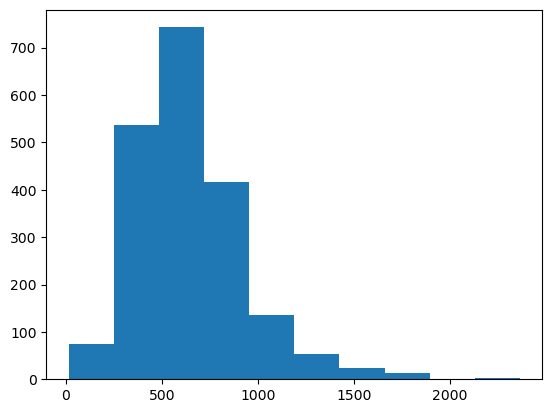

In [59]:
plt.hist(length)

In [60]:
X_train = train_data['text']
y_train = train_data['label']
X_test = test_data['text']
y_test = test_data['label']

In [61]:
t = Tokenizer()
t.fit_on_texts(X_train)
print(t.word_index)

{'the': 1, 'a': 2, 'and': 3, 'of': 4, 'to': 5, 'is': 6, 'in': 7, 'that': 8, 'it': 9, 'as': 10, 'with': 11, 'for': 12, 'his': 13, 'this': 14, 'film': 15, 'but': 16, 'he': 17, 'i': 18, 'on': 19, 'are': 20, 'by': 21, 'its': 22, 'be': 23, 'an': 24, 'one': 25, 'not': 26, 'who': 27, 'movie': 28, 'at': 29, 'was': 30, 'from': 31, 'have': 32, 'has': 33, 'you': 34, 'her': 35, 'they': 36, 'all': 37, 'like': 38, 'so': 39, 'out': 40, 'about': 41, 'more': 42, 'when': 43, 'which': 44, 'up': 45, 'or': 46, 'what': 47, 'their': 48, 'some': 49, 'just': 50, 'if': 51, 'there': 52, 'into': 53, 'him': 54, 'she': 55, 'even': 56, 'only': 57, 'no': 58, 'than': 59, 'good': 60, 'we': 61, 'time': 62, 'most': 63, 'can': 64, 'will': 65, 'films': 66, 'story': 67, 'been': 68, 'would': 69, 'much': 70, 'also': 71, 'get': 72, 'characters': 73, 'other': 74, 'do': 75, 'character': 76, 'very': 77, 'them': 78, 'first': 79, 'two': 80, 'see': 81, 'after': 82, 'well': 83, 'way': 84, 'because': 85, 'does': 86, 'really': 87, 'mak

In [62]:
L = int(length.quantile(.7))
X_train_seq = t.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_seq, maxlen=L, padding='post', truncating ='post')
X_train_padded[X_train_padded > 5000] = 0

X_test_seq = t.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq, maxlen=L, padding='post', truncating = 'post')
X_test_padded[X_test_padded > 5000] = 0

# [len(sub) for sub in X_train_padded]

## c. Word Embedding

In [64]:
MLP_model = Sequential([Embedding(5001, output_dim=32, input_length=L),
                   Flatten()]) 

## d.MLP

In [65]:
MLP_model.add(Dense(50, activation='relu'))
MLP_model.add(Dropout(0.2))
MLP_model.add(Dense(50, activation='relu')) 
MLP_model.add(Dropout(0.5))
MLP_model.add(Dense(50, activation='relu'))
MLP_model.add (Dropout(0.5))
MLP_model.add(Dense(1, activation='sigmoid'))

In [66]:
MLP_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [67]:
MLP_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = MLP_model.fit(X_train_padded, y_train, epochs=2, batch_size=10)

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5269 - loss: 0.6984
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5870 - loss: 0.6705


In [68]:
train_loss, train_accuracy = MLP_model.evaluate(X_train_padded, y_train)
test_loss, test_accuracy = MLP_model.evaluate(X_test_padded, y_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5989 - loss: 0.6263
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3694 - loss: 0.7775 


In [69]:
print(f"Evaluated Train Loss: {train_loss:.3f}")
print(f"Evaluated Train Accuracy: {train_accuracy:.3}")
print(f"Evaluated Test Loss: {test_loss:.3f}")
print(f"Evaluated Test Accuracy: {test_accuracy:.3f}")

Evaluated Train Loss: 0.531
Evaluated Train Accuracy: 0.759
Evaluated Test Loss: 0.692
Evaluated Test Accuracy: 0.557


## e. 1D CNN

In [73]:
CNN_model =  Sequential([
    Embedding(input_dim=5001, output_dim=32, input_length=L),  
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2, strides=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.5),                                            
    Dense(50, activation='relu'),
    Dropout(0.5),                                          
    Dense(1, activation='sigmoid')
])

In [74]:
CNN_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history2 = CNN_model.fit(X_train_padded, y_train, epochs=2, batch_size=10)

Epoch 1/2


140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5117 - loss: 0.6984
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5216 - loss: 0.6911


In [ ]:
train_loss, train_accuracy = CNN_model.evaluate(X_train_padded, y_train)
test_loss, test_accuracy = CNN_model.evaluate(X_test_padded, y_test)

2024-05-06 14:40:06.610114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 0s 10ms/step - loss: 0.6676 - accuracy: 0.5767


In [ ]:
print(f"Evaluated Train Loss: {train_loss:.3f}")
print(f"Evaluated Train Accuracy: {train_accuracy:.3}")
print(f"Evaluated Test Loss: {test_loss:.3f}")
print(f"Evaluated Test Accuracy: {test_accuracy:.3f}")

Evaluated Train Loss: 0.618
Evaluated Train Accuracy: 0.756
Evaluated Test Loss: 0.668
Evaluated Test Accuracy: 0.577


## f. LSTM RNN

In [75]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
LSTM_model = Sequential([
    Embedding(input_dim=5001, output_dim=32,input_length=L),
    tf.keras.layers.LSTM(32),
    Dropout(0.2),
    Dense(256,activation='relu'),
    Dropout(0.2),
    Dense(1,activation='sigmoid')
])

In [76]:
LSTM_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [77]:
LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [78]:
LSTM_model.fit(X_train_padded, y_train, epochs=10, batch_size=10)

Epoch 1/10


140/140 ━━━━━━━━━━━━━━━━━━━━ 24s 161ms/step - accuracy: 0.5457 - loss: 0.6921
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 210ms/step - accuracy: 0.5204 - loss: 0.6864
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - accuracy: 0.6508 - loss: 0.5949
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 0.6764 - loss: 0.5505
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 33s 240ms/step - accuracy: 0.6549 - loss: 0.5428
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - accuracy: 0.6795 - loss: 0.5000
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 0.6467 - loss: 0.4962
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - accuracy: 0.6061 - loss: 0.5156
Epoch 9/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 194ms/step - accuracy: 0.6740 - loss: 0.5117
Epoch 10/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - accuracy: 0.6928 - loss: 0.4820


In [79]:
train_loss, train_accuracy = LSTM_model.evaluate(X_train_padded, y_train)
test_loss, test_accuracy = LSTM_model.evaluate(X_test_padded, y_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4739 - loss: 0.4902
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3791 - loss: 0.9643


In [81]:
print(f"Evaluated Train Loss: {train_loss:.3f}")
print(f"Evaluated Train Accuracy: {train_accuracy:.3}")
print(f"Evaluated Test Loss: {test_loss:.3f}")
print(f"Evaluated Test Accuracy: {test_accuracy:.3f}")

Evaluated Train Loss: 0.482
Evaluated Train Accuracy: 0.682
Evaluated Test Loss: 0.996
Evaluated Test Accuracy: 0.572
